# EP Result Preiction Model Traing using XGBoost Algorithm

### 1. Donwload Required Deps

In [ ]:
# Download deps:
!pip install pandas
!pip install scikit-learn
!pip install xgboost

### 2. Import Required Deps

In [14]:
# Import dependencies
import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

### 3. Load and Explore the Dataset

In [3]:
# Load data
df = pd.read_csv("C:\My_Files\Projects\ep_2024_25_result_prediction\EPL_Results_2024_25.csv") 

In [4]:
# Preview the original dataset (df):
print("Initial shape:", df.shape)
print("Available columns:", df.columns.tolist())
print(df.head())                         # The first 5 rows

(380, 120)
Index(['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
       'HTHG', 'HTAG',
       ...
       'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA', 'MaxCAHH', 'MaxCAHA',
       'AvgCAHH', 'AvgCAHA', 'BFECAHH', 'BFECAHA'],
      dtype='object', length=120)


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,BFECAHH,BFECAHA
0,E0,16/08/2024,20:00,Man United,Fulham,1,0,H,0,0,...,1.86,2.07,1.83,2.11,1.88,2.11,1.82,2.05,1.90,2.08
1,E0,17/08/2024,12:30,Ipswich,Liverpool,0,2,A,0,0,...,2.05,1.88,2.04,1.90,2.20,2.00,1.99,1.88,2.04,1.93
2,E0,17/08/2024,15:00,Arsenal,Wolves,2,0,H,1,0,...,2.02,1.91,2.00,1.90,2.05,1.93,1.99,1.87,2.02,1.96
3,E0,17/08/2024,15:00,Everton,Brighton,0,3,A,0,1,...,1.87,2.06,1.86,2.07,1.92,2.10,1.83,2.04,1.88,2.11
4,E0,17/08/2024,15:00,Newcastle,Southampton,1,0,H,1,0,...,1.87,2.06,1.88,2.06,1.89,2.10,1.82,2.05,1.89,2.10


### 4. Pre-process the dataset: Feature Selection & Cleaning

In [ ]:
# Keywords fro relevant features to stay: 
'''
Annotated Football Match Features I used:
1. 'FTHG': Full Time Home Goals - The total number of goals scored by the home team at the end of regular time (90 minutes + injury time).
2. 'FTAG': Full Time Away Goals - The total number of goals scored by the away team at the end of regular time.
3. 'HS': Home Shots - The total number of shot attempts made by the home team during the entire match. This includes shots on target, off target, and blocked shots.
4. 'AS': Away Shots - The total number of shot attempts made by the away team during the entire match.
5. 'HST': Home Shots on Target - The number of shots taken by the home team that were directed at the goal and would have entered the goal if not for a save by the goalkeeper or a block by a defender (who is not the goalkeeper).
6. 'AST': Away Shots on Target - The number of shots taken by the away team that were on target.
7. 'HF': Home Fouls - The total number of fouls committed by the home team during the match.
8. 'AF': Away Fouls - The total number of fouls committed by the away team during the match.
9. 'HC': Home Corners - The total number of corner kicks awarded to the home team during the match.
10. 'AC': Away Corners - The total number of corner kicks awarded to the away team during the match.
11. 'HY': Home Yellow Cards - The total number of yellow cards issued to players of the home team during the match. A yellow card is a caution.
12. 'AY': Away Yellow Cards - The total number of yellow cards issued to players of the away team during the match.
13. 'HR': Home Red Cards - The total number of red cards issued to players of the home team during the match. A red card results in the player being sent off and unable to continue playing.
14. 'AR': Away Red Cards - The total number of red cards issued to players of the away team during the match.
15. 'B365H': Bet365 Home Win Odds - The betting odds offered by the bookmaker Bet365 for the home team to win the match. Lower odds typically indicate a higher perceived probability of that outcome.
16. 'B365D': Bet365 Draw Odds - The betting odds offered by Bet365 for the match to end in a draw.
17. 'B365A': Bet365 Away Win Odds - The betting odds offered by Bet365 for the away team to win the match.
18. 'FTR': Full Time Result - This is typically your target variable for prediction. It represents the final outcome of the match, often encoded as:
        'H': Home team wins
        'D': Draw
        'A': Away team wins
'''

In [5]:
# Keep relevant 18 features from the whole 120 features:
features = [
    'FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF',
    'HC', 'AC', 'HY', 'AY', 'HR', 'AR',
    'B365H', 'B365D', 'B365A',
    'FTR'  # Target column
]
df = df[features]

# Drop missing values
df.dropna(inplace=True)
print("Cleaned data shape:", df.shape)                                 # Drop rows with missing values

In [7]:
# Preview the cleaned dataset (df):
print(df.shape)
print(df.columns)
df.head()

(380, 18)
Index(['FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY',
       'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'FTR'],
      dtype='object')


,FTHG,FTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,FTR
0,1,0,14,10,5,2,12,10,7,8,2,3,0,0,1.60,4.20,5.25,H
1,0,2,7,18,2,5,9,18,2,10,3,1,0,0,8.50,5.50,1.33,A
2,2,0,18,9,6,3,17,14,8,2,2,2,0,0,1.18,7.50,13.00,H
3,0,3,9,10,1,5,8,8,1,5,1,1,1,0,2.63,3.30,2.63,A
4,1,0,3,19,1,4,15,16,3,12,2,4,1,0,1.36,5.25,8.00,H


### 5.  Encode Target Variables

In [11]:
# Encode variables for FTR:
'''
=> H = 0 
=> D = 1 
=> A = 2
'''

le = LabelEncoder()
df['FTR'] = le.fit_transform(df['FTR'])

# Show mapping
print("Encoded FTR classes:", list(le.classes_))
print("Target distribution:\n", df['FTR'].value_counts())

Target distribution:
 FTR
2    155
0    132
1     93
Name: count, dtype: int64


### 6. Split the above Dataset (df)

In [13]:
# Split the dataset (df):
'''
=> 80% : training
=> 20% : testing

'''

X = df.drop(columns='FTR')
y = df['FTR']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

### 7. Rerain the XGBoost Model

In [16]:
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)

# --------------------------
# Evaluation
# --------------------------
y_pred = xgb_model.predict(X_test)

print("\n✅ Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))  # Use real labels

c:\My_Files\Projects\ai_venv_310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:46:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[[26  0  0]
 [ 0 18  1]
 [ 0  0 31]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      0.95      0.97        19
           2       0.97      1.00      0.98        31

    accuracy                           0.99        76
   macro avg       0.99      0.98      0.99        76
weighted avg       0.99      0.99      0.99        76



### 8. Feature Importance (XGBoost)

<Figure size 1000x800 with 0 Axes>

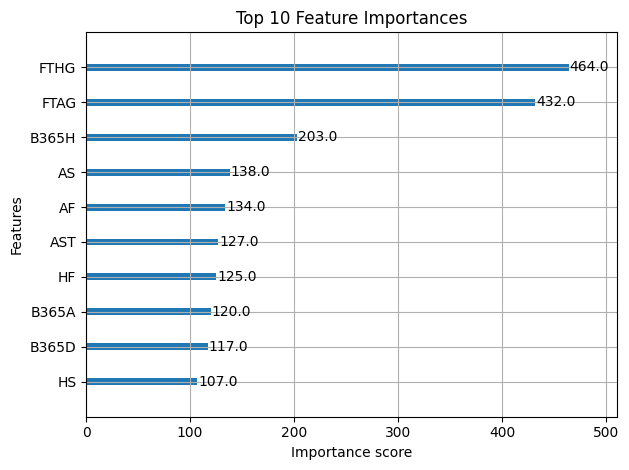

In [17]:
# Plot the features:
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()

### 9. Save the Model for Deployment

In [19]:
joblib.dump(xgb_model, r"C:\My_Files\Projects\ep_2024_25_result_prediction\xgb_ftr_model.pkl")  # Change as per ur dir
joblib.dump(le, r"C:\My_Files\Projects\ep_2024_25_result_prediction\ftr_label_encoder.pkl")     # Change as per ur dir

print("\n✅ Model and label encoder saved.")

['C:\\My_Files\\Projects\\ep_2024_25_result_prediction\\ftr_label_encoder.pkl']